
=== Dataset Cleaning Summary (Per Source) ===
Facebook:
   Original rows: 210
   Kept rows:     105
   Removed rows:  105 (50.00%)
   • Dropped due to missing caption/date: 105 (50.00%)

Instagram:
   Original rows: 3544
   Kept rows:     19
   Removed rows:  3525 (99.46%)
   • Dropped due to missing caption/date: 3525 (99.46%)

Engagement_Report:
   Original rows: 655
   Kept rows:     655
   Removed rows:  0 (0.00%)

=== Overall Totals ===
Total original rows: 4409
Total kept rows:     779
Total removed rows:  3630 (82.33%)

Merged rows (before dropna): (124, 6)
Merged rows (after dropna): (13, 6)
Skipping day-of-week plot per guidance (date features not used).


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/faitusjelinejoseph/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


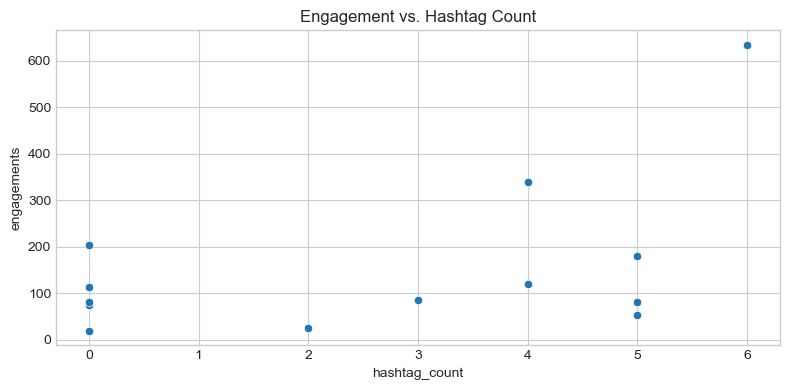

Final dataset exported to: final_merged_social_data.csv

 Sample Output:
     post_date    museum_name  \
1   2024-04-15  Ulster Museum   
11  2024-04-30  Ulster Museum   
19  2024-05-24  Ulster Museum   
27  2024-07-04  Ulster Museum   
34  2024-07-31  Ulster Museum   

                                              caption  platform  engagements  \
1   Around 60 people from different communities to...  facebook         85.0   
11  Important visitor notice for Wednesday 1st May...  facebook         75.0   
19  Discover Caravaggio's 'The Supper at Emmaus', ...  facebook         54.0   
27  The Supper at Emmaus by Caravaggio, depicts th...  facebook        120.0   
34  Go for Gold! Congratulations to Daniel Wiffen,...  facebook        204.0   

      reach  hashtag_count day_of_week month  sentiment  
1    1059.0              3         N/A   N/A     0.9758  
11   2228.0              0         N/A   N/A     0.5423  
19   2401.0              5         N/A   N/A     0.6597  
27   7320.0    

In [21]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# 1. Load Data
# -----------------------------
fb_path = "/Users/faitusjelinejoseph/Documents/Project/Social/Final_Facebook_Posts_With_Captions.xlsx"
ig_path = "/Users/faitusjelinejoseph/Documents/Project/Social/Instagram captions.xlsx"
report_path = "/Users/faitusjelinejoseph/Documents/Project/Social/Digital Engagement Report 2024-25.xlsx"

fb_df = pd.read_excel(fb_path, sheet_name='Sheet1')
ig_df = pd.read_excel(ig_path, sheet_name='Sheet1')
report_data = pd.read_excel(report_path, sheet_name=None)
activity_df = report_data['Social Activity Tracker']

# Track original counts (for summary)
orig_counts = {
    "facebook": len(fb_df),
    "instagram": len(ig_df),
    "engagement_report": len(activity_df)
}

# -----------------------------
# 2. Clean Facebook & Instagram
# -----------------------------
fb_df_cleaned = fb_df.rename(columns={
    'Post Date': 'post_date',
    'Museum Name': 'museum_name',
    'Formatted Facebook Caption': 'caption'
})
fb_df_cleaned['platform'] = 'facebook'

ig_df_cleaned = ig_df.rename(columns={
    'Date Posted': 'post_date',
    'Museum Site': 'museum_name',
    'Full Caption': 'caption'
})
ig_df_cleaned['platform'] = 'instagram'

fb_df_cleaned = fb_df_cleaned[['post_date', 'museum_name', 'caption', 'platform']]
ig_df_cleaned = ig_df_cleaned[['post_date', 'museum_name', 'caption', 'platform']]
combined_posts = pd.concat([fb_df_cleaned, ig_df_cleaned], ignore_index=True)

# Parse dates
combined_posts['post_date'] = pd.to_datetime(combined_posts['post_date'], errors='coerce').dt.date

# Save counts before dropping to report specific losses due to missing caption/date
combined_posts_pre_drop = combined_posts.copy()

# Drop rows missing caption or date (join requirement)
combined_posts = combined_posts.dropna(subset=['caption', 'post_date'])

# -----------------------------
# 3. Clean Engagement Report
# -----------------------------
activity_df_cleaned = activity_df.rename(columns={
    'Day': 'day',
    'Month': 'month',
    'Site': 'site',
    'Content Type': 'content_type',
    'Total Active Engagements (Like, Comment, Share, Video >15s)': 'engagements',
    'Total Reach': 'reach'
}).dropna(subset=['site', 'month'])

activity_df_cleaned = activity_df_cleaned[~activity_df_cleaned['site'].isin(['NNMI'])]

month_str_to_num = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
activity_df_cleaned['month'] = activity_df_cleaned['month'].map(month_str_to_num)

# Use median-like placeholder 15 ONLY to form a joinable date; not for analysis
activity_df_cleaned['day'] = activity_df_cleaned['day'].fillna(15).astype(int)

activity_df_cleaned['post_date'] = pd.to_datetime({
    'year': 2024,
    'month': activity_df_cleaned['month'],
    'day': activity_df_cleaned['day']
}, errors='coerce').dt.date

site_to_museum = {
    'UM': 'Ulster Museum',
    'UTM': 'Ulster Transport Museum',
    'UAFP': 'Ulster American Folk Park',
    'AFP': 'Ulster American Folk Park',
    'UFM': 'Ulster Folk Museum'
}
activity_df_cleaned['museum_name'] = activity_df_cleaned['site'].map(site_to_museum)
activity_df_cleaned['platform'] = activity_df_cleaned['content_type'].apply(
    lambda x: 'facebook' if isinstance(x, str) and 'Facebook' in x else 'instagram'
)

# -----------------------------
# 3a. Cleaning Summary (per dataset + overall)
# -----------------------------
# Final kept rows for FB/IG after required filtering
kept_fb = int((combined_posts['platform'] == 'facebook').sum())
kept_ig = int((combined_posts['platform'] == 'instagram').sum())
kept_eng = int(len(activity_df_cleaned))

clean_counts = {
    "facebook": kept_fb,
    "instagram": kept_ig,
    "engagement_report": kept_eng
}

def pct(removed, orig):
    return (removed / orig * 100.0) if orig > 0 else 0.0

removed_counts = {k: int(orig_counts[k] - clean_counts[k]) for k in orig_counts}
removed_pcts = {k: pct(removed_counts[k], orig_counts[k]) for k in orig_counts}

# Also: specific FB/IG drops due to missing caption/date
pre_fb = int((combined_posts_pre_drop['platform'] == 'facebook').sum())
pre_ig = int((combined_posts_pre_drop['platform'] == 'instagram').sum())
drop_fb_caption_date = pre_fb - kept_fb
drop_ig_caption_date = pre_ig - kept_ig

print("\n=== Dataset Cleaning Summary (Per Source) ===")
for ds in ["facebook", "instagram", "engagement_report"]:
    print(f"{ds.title()}:")
    print(f"   Original rows: {orig_counts[ds]}")
    print(f"   Kept rows:     {clean_counts[ds]}")
    print(f"   Removed rows:  {removed_counts[ds]} ({removed_pcts[ds]:.2f}%)")
    if ds in ["facebook", "instagram"]:
        specific = drop_fb_caption_date if ds == "facebook" else drop_ig_caption_date
        pre_ct = pre_fb if ds == "facebook" else pre_ig
        spec_pct = pct(specific, pre_ct) if pre_ct > 0 else 0.0
        print(f"   • Dropped due to missing caption/date: {specific} ({spec_pct:.2f}%)")
    print()

total_orig = sum(orig_counts.values())
total_kept = sum(clean_counts.values())
total_removed = total_orig - total_kept
total_removed_pct = pct(total_removed, total_orig)

print("=== Overall Totals ===")
print(f"Total original rows: {total_orig}")
print(f"Total kept rows:     {total_kept}")
print(f"Total removed rows:  {total_removed} ({total_removed_pct:.2f}%)\n")

# -----------------------------
# 4. Merge Datasets
# -----------------------------
merged_df = pd.merge(
    combined_posts,
    activity_df_cleaned[['post_date', 'museum_name', 'platform', 'engagements', 'reach']],
    on=['post_date', 'museum_name', 'platform'],
    how='left'
)
print("Merged rows (before dropna):", merged_df.shape)

merged_df = merged_df.dropna(subset=['engagements'])
print("Merged rows (after dropna):", merged_df.shape)

# -----------------------------
# 5. Feature Engineering
# -----------------------------
merged_df['hashtag_count'] = merged_df['caption'].fillna('').apply(lambda x: x.count('#'))
merged_df['hour_of_day'] = 0  # No timestamp info

# Build but neutralize date-derived fields for analysis (keep columns for preview/export)
merged_df['day_of_week'] = 'N/A'  # do not use for analysis
merged_df['month'] = 'N/A'        # do not use for analysis

# Sentiment Analysis
nltk.download('vader_lexicon')  # <- Only needed once
sia = SentimentIntensityAnalyzer()
merged_df['sentiment'] = merged_df['caption'].fillna('').apply(lambda x: sia.polarity_scores(x)['compound'])

# -----------------------------
# 6. Visualizations
# -----------------------------
PLOT_DAY_OF_WEEK = False  # per guidance: don't use dates for analysis

if not merged_df.empty:
    if PLOT_DAY_OF_WEEK:
        plt.figure(figsize=(10, 5))
        sns.boxplot(x='day_of_week', y='engagements', data=merged_df)
        plt.title('Engagement by Day of Week')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping day-of-week plot per guidance (date features not used).")

    plt.figure(figsize=(8, 4))
    sns.scatterplot(x='hashtag_count', y='engagements', data=merged_df)
    plt.title('Engagement vs. Hashtag Count')
    plt.tight_layout()
    plt.show()
else:
    print("No data available for visualization.")

# -----------------------------
# 7. Export Cleaned Dataset
# -----------------------------
merged_df.to_csv("/Users/faitusjelinejoseph/Documents/Project/Social/final_merged_social_data.csv", index=False)
print("Final dataset exported to: final_merged_social_data.csv")

# -----------------------------
# 8. Preview
# -----------------------------
print("\n Sample Output:")
print(merged_df[['post_date', 'museum_name', 'caption', 'platform', 'engagements',
                 'reach', 'hashtag_count', 'day_of_week', 'month', 'sentiment']].head())


Loaded: /Users/faitusjelinejoseph/Documents/Project/Social/final_merged_social_data.csv -> (13, 11)
Best params: {'model__subsample': 0.6, 'model__reg_lambda': 0.0, 'model__reg_alpha': 0.0, 'model__num_leaves': 31, 'model__n_estimators': 800, 'model__min_child_samples': 10, 'model__max_depth': -1, 'model__learning_rate': 0.03, 'model__colsample_bytree': 0.8}
Test RMSE: 70.23
Test MAE : 63.40
Test R^2 : -4.4033

Top 25 features by importance:
                feature  importance
0                    00           0
114  ng200 michelangelo           0
116    northern ireland           0
117                  of           0
118           of christ           0
119           of modern           0
120              of the           0
121                  on           0
122              on the           0
123                open           0
124                 our           0
125            painting           0
126              please           0
127           presented           0
128        pre

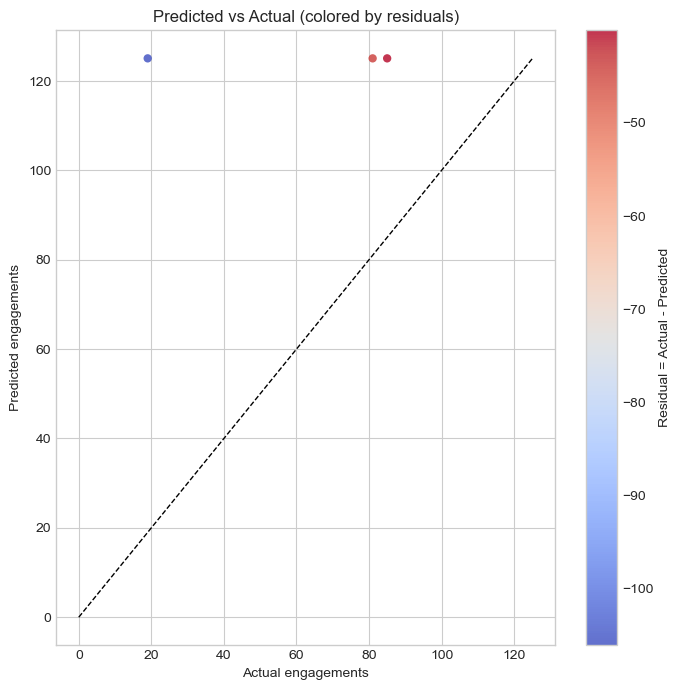

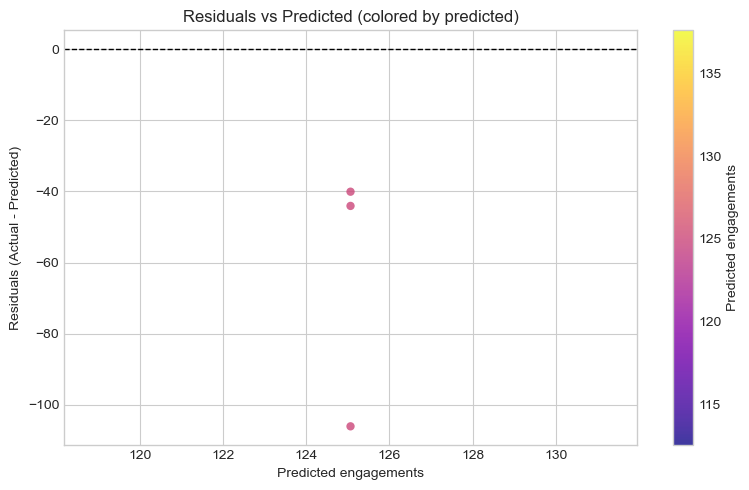

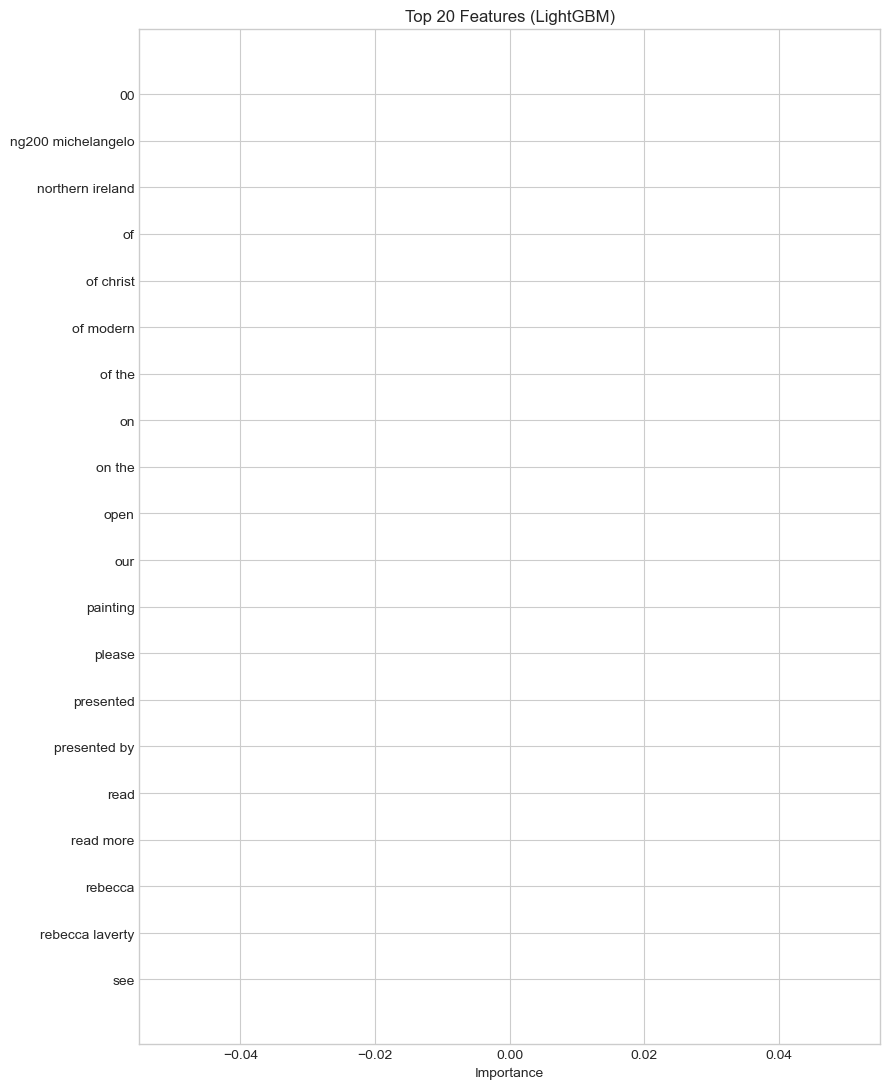

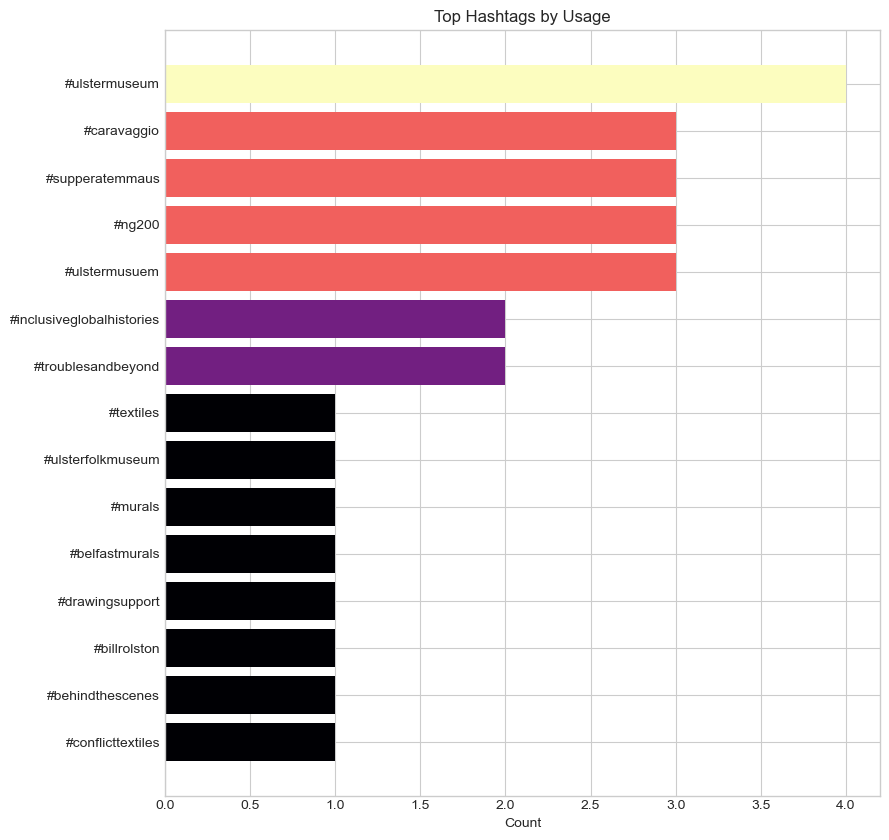

[Info] No hashtags satisfy min-uses=5 for avg engagement plot.


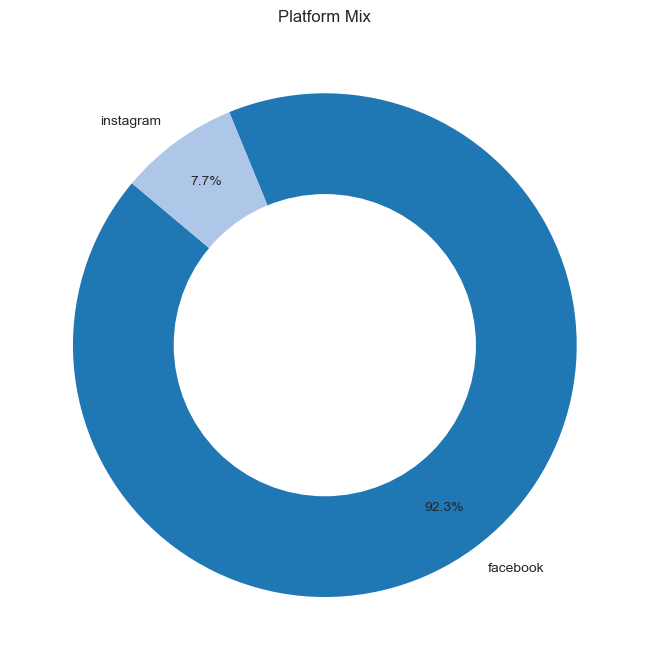

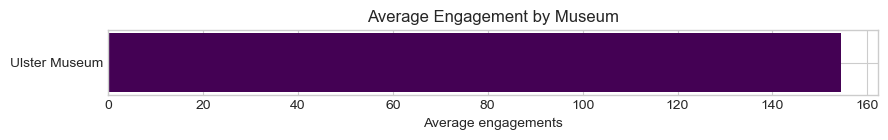

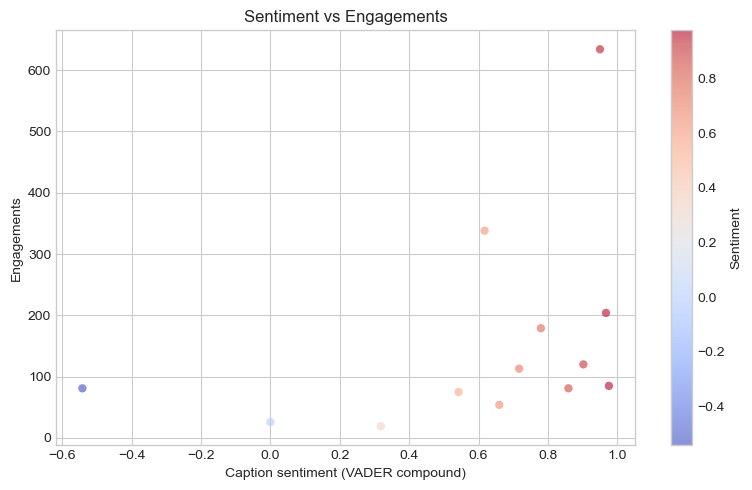

In [22]:
# =============================
# 9) Model-ready features  (reads from CSV, no date-based features)
# =============================
import os, re, math, warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
from sklearn.exceptions import ConvergenceWarning
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
os.environ["PYTHONWARNINGS"] = "ignore"

CSV_PATH = "/Users/faitusjelinejoseph/Documents/Project/Social/final_merged_social_data.csv"
df = pd.read_csv(CSV_PATH)
print(f"Loaded: {CSV_PATH} -> {df.shape}")

# Ensure essential columns exist
for col in ["caption", "engagements", "museum_name", "platform"]:
    if col not in df.columns:
        raise KeyError(f"Missing required column in CSV: {col}")

# --- Per guidance: DO NOT use dates for analysis ---
# If 'day_of_week'/'month' exist, neutralize to a single category so they carry no signal
if "day_of_week" in df.columns:
    df["day_of_week"] = "N/A"
if "month" in df.columns:
    df["month"] = "N/A"

# Sentiment present? If not, add it (text-only, date-agnostic)
if "sentiment" not in df.columns:
    try:
        nltk.data.find('sentiment/vader_lexicon.zip')
    except LookupError:
        nltk.download('vader_lexicon')
    _sia = SentimentIntensityAnalyzer()
    df["sentiment"] = df["caption"].fillna("").apply(lambda t: _sia.polarity_scores(str(t))["compound"])
else:
    _sia = SentimentIntensityAnalyzer()

# Hashtag count present? If not, add it.
if "hashtag_count" not in df.columns:
    df["hashtag_count"] = df["caption"].fillna("").str.count("#")

# Extra lightweight text/structure features
def count_emojis(text):
    if not isinstance(text, str): 
        return 0
    # crude emoji-ish proxy: non-word/space/common punct and not #/@
    return len(re.findall(r"[^\w\s#@.,!?'\-:;()/&]", text))

df["caption"] = df["caption"].fillna("")
df["engagements"] = pd.to_numeric(df["engagements"], errors="coerce")
df = df.dropna(subset=["engagements"])  # must have target

df["caption_len"] = df["caption"].apply(len)
df["word_count"]  = df["caption"].apply(lambda x: len(x.split()))
df["emoji_count"] = df["caption"].apply(count_emojis)

# Target (log1p for stability)
y = np.log1p(df["engagements"].astype(float))

# Feature sets (keep day_of_week/month only if they exist, but they are neutralized to "N/A")
text_col = "caption"
cat_cols = [c for c in ["museum_name", "platform", "day_of_week", "month"] if c in df.columns]
num_cols = [c for c in ["hashtag_count", "sentiment", "caption_len", "word_count", "emoji_count"] if c in df.columns]

X = df[[text_col] + cat_cols + num_cols].copy()

# Train/valid split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=None  # regression
)

# =============================
# 10) Preprocessing + Model
# =============================
text_vec = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2),
    min_df=2,
    lowercase=True,
)

cat_enc = OneHotEncoder(handle_unknown='ignore', sparse=True)

from sklearn.compose import ColumnTransformer
preprocess = ColumnTransformer(
    transformers=[
        ('text', text_vec, text_col),
        ('cat',  cat_enc, cat_cols) if cat_cols else ('cat', 'drop', []),
        ('num',  'passthrough', num_cols) if num_cols else ('num', 'drop', [])
    ],
    remainder='drop',
    sparse_threshold=0.3
)

model = lgb.LGBMRegressor(
    objective='regression',
    random_state=42,
    n_estimators=400,
    learning_rate=0.05,
    verbosity=-1
)

from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('prep', preprocess),
    ('model', model)
])

# =============================
# 11) Model selection (random search)
# =============================
param_dist = {
    'model__n_estimators': [200, 400, 600, 800],
    'model__learning_rate': [0.03, 0.05, 0.1],
    'model__num_leaves': [31, 63, 127],
    'model__max_depth': [-1, 6, 8, 10],
    'model__min_child_samples': [10, 20, 30, 50],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__reg_alpha': [0.0, 0.1, 0.3],
    'model__reg_lambda': [0.0, 0.5, 1.0],
}

from sklearn.model_selection import RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=25,
    cv=5,
    n_jobs=-1,
    random_state=42,
    scoring='neg_root_mean_squared_error',
    verbose=0
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    search.fit(X_train, y_train)

best_pipe = search.best_estimator_
print("Best params:", search.best_params_)

# =============================
# 12) Evaluation (on original scale)
# =============================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred_log = best_pipe.predict(X_test)
y_pred = np.expm1(y_pred_log)         # invert the log1p
y_true = np.expm1(y_test.to_numpy())

rmse = math.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

print(f"Test RMSE: {rmse:,.2f}")
print(f"Test MAE : {mae:,.2f}")
print(f"Test R^2 : {r2:.4f}")

# =============================
# 13) Feature importance (global)
# =============================
def get_feature_names_from_ct(ct: ColumnTransformer):
    names = []
    for name, trans, cols in ct.transformers_:
        if name == 'remainder' and trans == 'drop':
            continue
        if hasattr(trans, 'get_feature_names_out'):
            if isinstance(trans, OneHotEncoder):
                feats = trans.get_feature_names_out(cols)
            else:
                feats = trans.get_feature_names_out()
            names.extend(list(feats))
        elif trans == 'passthrough':
            if isinstance(cols, list):
                names.extend(cols)
            else:
                names.append(cols)
        else:
            if isinstance(cols, list):
                names.extend([f"{name}__{c}" for c in cols])
            else:
                names.append(f"{name}__{cols}")
    return np.array(names)

lgbm = best_pipe.named_steps['model']
ct   = best_pipe.named_steps['prep']
feat_names = get_feature_names_from_ct(ct)

importances = pd.DataFrame({
    'feature': feat_names,
    'importance': lgbm.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 25 features by importance:")
print(importances.head(25))

# =============================
# 14) Optimal hashtags (data-driven)
# =============================
def extract_hashtags(text):
    if not isinstance(text, str): return []
    return [h.lower() for h in re.findall(r'#\w+', text)]

need_cols = ['caption', 'engagements', 'museum_name', 'platform']
for c in need_cols:
    if c not in df.columns:
        df[c] = np.nan

# We keep day_of_week/month columns if they exist (will be "N/A")
extra_cols = [c for c in ['day_of_week', 'month'] if c in df.columns]
tag_df = df[need_cols + extra_cols].copy()
tag_df['hashtags'] = tag_df['caption'].apply(extract_hashtags)
tag_exp = tag_df.explode('hashtags').dropna(subset=['hashtags'])

counts = tag_exp.groupby('hashtags').size().rename('count')
means  = tag_exp.groupby('hashtags')['engagements'].mean().rename('avg_engagement')
tag_stats = pd.concat([counts, means], axis=1).reset_index().sort_values('avg_engagement', ascending=False)

print("\nHashtag stats (top 15 by avg engagement, any frequency):")
print(tag_stats.head(15))

# =============================
# 15) Best posting day per museum (SKIPPED per guidance)
# =============================
if 'day_of_week' in df.columns and df['day_of_week'].nunique() > 1:
    print("\n[Skipped] Best posting day per museum — date-based analysis disabled by guidance.")
else:
    print("\nBest posting day per museum skipped (no date features used / single neutral category).")

# =============================
# 16) Predict for a *new* post (pre-publish) — ignores date
# =============================
def predict_engagement(caption, museum_name, platform, post_date=None):
    """
    Per guidance, we IGNORE post_date (no date effects).
    """
    cap = caption or ""
    row = {
        'caption': cap,
        'museum_name': museum_name,
        'platform': platform,
        # Keep columns consistent; if present in training, set to neutral
        'day_of_week': 'N/A' if 'day_of_week' in X.columns else np.nan,
        'month': 'N/A' if 'month' in X.columns else np.nan,
        'hashtag_count': cap.count('#'),
        'sentiment': _sia.polarity_scores(cap)['compound'],
        'caption_len': len(cap),
        'word_count': len(cap.split()),
        'emoji_count': count_emojis(cap),
    }
    X_new = pd.DataFrame([row])
    pred_log = best_pipe.predict(X_new)[0]
    return float(max(0.0, np.expm1(pred_log)))

# =============================
# 17) Colorful Visuals (no date features)
# =============================
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

PLOT_DIR = "/Users/faitusjelinejoseph/Documents/Project/Social/plots"
os.makedirs(PLOT_DIR, exist_ok=True)
plt.style.use("seaborn-v0_8-whitegrid")  # clean, color-friendly base

def _cm_colors(values, cmap_name="viridis"):
    """Map 1D numeric array -> RGBA colors using a colormap."""
    values = np.asarray(values, dtype=float)
    vmin, vmax = float(np.nanmin(values)), float(np.nanmax(values))
    if np.isclose(vmin, vmax):
        vmax = vmin + 1.0
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)
    return cmap(norm(values))

# ---- 17.1 Predicted vs Actual (colored by residuals) ----
try:
    residuals = y_true - y_pred
    sc_cmap = "coolwarm"
    plt.figure(figsize=(7, 7))
    sc = plt.scatter(y_true, y_pred, c=residuals, cmap=sc_cmap, alpha=0.8, edgecolor="none")
    mx = max(float(np.max(y_true)), float(np.max(y_pred))) if len(y_true) else 1.0
    plt.plot([0, mx], [0, mx], linestyle="--", color="black", linewidth=1.0)
    plt.xlabel("Actual engagements")
    plt.ylabel("Predicted engagements")
    plt.title("Predicted vs Actual (colored by residuals)")
    cbar = plt.colorbar(sc)
    cbar.set_label("Residual = Actual - Predicted")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "pred_vs_actual_color.png"), dpi=150)
    plt.show()
except Exception as e:
    print(f"[Skip] Predicted vs Actual plot: {e}")

# ---- 17.2 Residuals vs Predicted (colored by predicted) ----
try:
    plt.figure(figsize=(8, 5))
    sc = plt.scatter(y_pred, residuals, c=y_pred, cmap="plasma", alpha=0.8, edgecolor="none")
    plt.axhline(0, linestyle="--", color="black", linewidth=1.0)
    plt.xlabel("Predicted engagements")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title("Residuals vs Predicted (colored by predicted)")
    cbar = plt.colorbar(sc)
    cbar.set_label("Predicted engagements")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "residuals_vs_pred_color.png"), dpi=150)
    plt.show()
except Exception as e:
    print(f"[Skip] Residuals vs Predicted plot: {e}")

# ---- 17.3 Feature importances (Top 20, colorful barh) ----
try:
    if isinstance(importances, pd.DataFrame) and not importances.empty:
        top_n = 20
        top_imp = importances.head(top_n).iloc[::-1]  # reverse for barh
        cols = _cm_colors(top_imp["importance"].values, "viridis")

        plt.figure(figsize=(9, 0.5 * len(top_imp) + 1))
        plt.barh(top_imp["feature"], top_imp["importance"], color=cols)
        plt.xlabel("Importance")
        plt.title(f"Top {len(top_imp)} Features (LightGBM)")
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, "feature_importance_top_color.png"), dpi=150)
        plt.show()
    else:
        print("[Info] No importances available to plot.")
except Exception as e:
    print(f"[Skip] Feature importance plot: {e}")

# ---- 17.4 Top hashtags by usage (color by count) ----
try:
    def extract_hashtags(text):
        if not isinstance(text, str): return []
        return [h.lower() for h in re.findall(r'#\w+', text)]

    tmp = df[['caption','engagements']].copy()
    tmp["caption"] = tmp["caption"].fillna("")
    tmp["hashtags"] = tmp["caption"].apply(extract_hashtags)
    tmp = tmp.explode("hashtags").dropna(subset=["hashtags"])
    top_cnt = (tmp["hashtags"].value_counts()
               .head(15)
               .rename_axis("hashtags")
               .reset_index(name="count"))

    if not top_cnt.empty:
        d = top_cnt.iloc[::-1]
        cols = _cm_colors(d["count"].values, "magma")
        plt.figure(figsize=(9, 0.5 * len(d) + 1))
        plt.barh(d["hashtags"], d["count"], color=cols)
        plt.xlabel("Count")
        plt.title("Top Hashtags by Usage")
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, "top_hashtags_usage_color.png"), dpi=150)
        plt.show()
    else:
        print("[Info] No hashtags found for usage plot.")
except Exception as e:
    print(f"[Skip] Top hashtags by usage plot: {e}")

# ---- 17.5 Top hashtags by average engagement (min 5 uses; color by avg_engagement) ----
try:
    grp = (tmp.groupby("hashtags")["engagements"]
             .agg(count="size", avg_engagement="mean")
             .query("count >= 5")
             .sort_values(["avg_engagement","count"], ascending=[False, False])
             .head(15)
             .reset_index())

    if not grp.empty:
        d = grp.iloc[::-1]
        cols = _cm_colors(d["avg_engagement"].values, "cividis")
        plt.figure(figsize=(9, 0.5 * len(d) + 1))
        plt.barh(d["hashtags"], d["avg_engagement"], color=cols)
        plt.xlabel("Average engagements")
        plt.title("Top Hashtags by Avg Engagement (≥5 uses)")
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, "top_hashtags_avg_color.png"), dpi=150)
        plt.show()
    else:
        print("[Info] No hashtags satisfy min-uses=5 for avg engagement plot.")
except Exception as e:
    print(f"[Skip] Top hashtags by avg engagement plot: {e}")

# ---- 17.6 Platform mix (colorful donut) ----
try:
    if "platform" in df.columns:
        counts = df["platform"].fillna("unknown").value_counts()
        labels = counts.index.tolist()
        sizes = counts.values
        cmap = cm.get_cmap("tab20")
        colors = [cmap(i % cmap.N) for i in range(len(labels))]

        plt.figure(figsize=(6.8, 6.8))
        wedges, texts, autotexts = plt.pie(
            sizes, labels=labels, autopct="%1.1f%%",
            startangle=140, colors=colors, pctdistance=0.8
        )
        centre_circle = plt.Circle((0,0),0.60,fc="white")
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)
        plt.title("Platform Mix")
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, "platform_mix_donut.png"), dpi=150)
        plt.show()
    else:
        print("[Info] 'platform' column not found for platform mix.")
except Exception as e:
    print(f"[Skip] Platform mix plot: {e}")

# ---- 17.7 Museum averages (color by avg engagement) ----
try:
    if "museum_name" in df.columns:
        mus = (df.groupby("museum_name")["engagements"]
                 .mean()
                 .sort_values(ascending=False)
                 .reset_index()
                 .rename(columns={"engagements":"avg_engagement"}))
        if not mus.empty:
            d = mus.iloc[::-1]
            cols = _cm_colors(d["avg_engagement"].values, "viridis")
            plt.figure(figsize=(9, 0.5 * len(d) + 1))
            plt.barh(d["museum_name"], d["avg_engagement"], color=cols)
            plt.xlabel("Average engagements")
            plt.title("Average Engagement by Museum")
            plt.tight_layout()
            plt.savefig(os.path.join(PLOT_DIR, "avg_engagement_by_museum.png"), dpi=150)
            plt.show()
        else:
            print("[Info] No museum data available.")
    else:
        print("[Info] 'museum_name' column not found for museum averages.")
except Exception as e:
    print(f"[Skip] Museum averages plot: {e}")

# ---- 17.8 Sentiment vs Engagements (colored by sentiment) ----
try:
    if "sentiment" in df.columns and not df["sentiment"].isna().all():
        x = pd.to_numeric(df["sentiment"], errors="coerce")
        y_vals = pd.to_numeric(df["engagements"], errors="coerce")
        mask = (~x.isna()) & (~y_vals.isna())
        x, y_vals = x[mask], y_vals[mask]
        plt.figure(figsize=(8, 5))
        sc = plt.scatter(x, y_vals, c=x, cmap="coolwarm", alpha=0.6, edgecolor="none")
        plt.xlabel("Caption sentiment (VADER compound)")
        plt.ylabel("Engagements")
        plt.title("Sentiment vs Engagements")
        cbar = plt.colorbar(sc)
        cbar.set_label("Sentiment")
        plt.tight_layout()
        plt.savefig(os.path.join(PLOT_DIR, "sentiment_vs_engagements.png"), dpi=150)
        plt.show()
    else:
        print("[Info] Sentiment column not available for plotting.")
except Exception as e:
    print(f"[Skip] Sentiment vs Engagements plot: {e}")


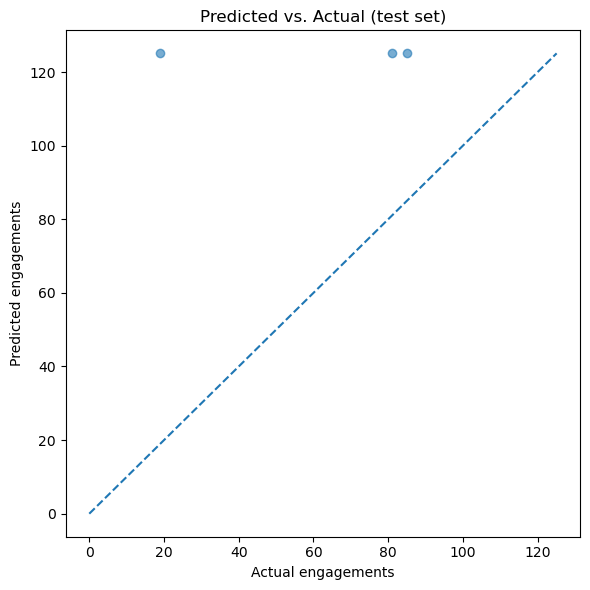

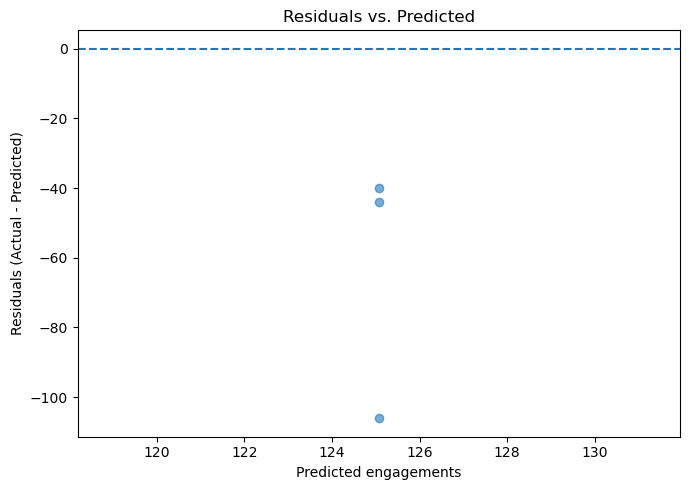

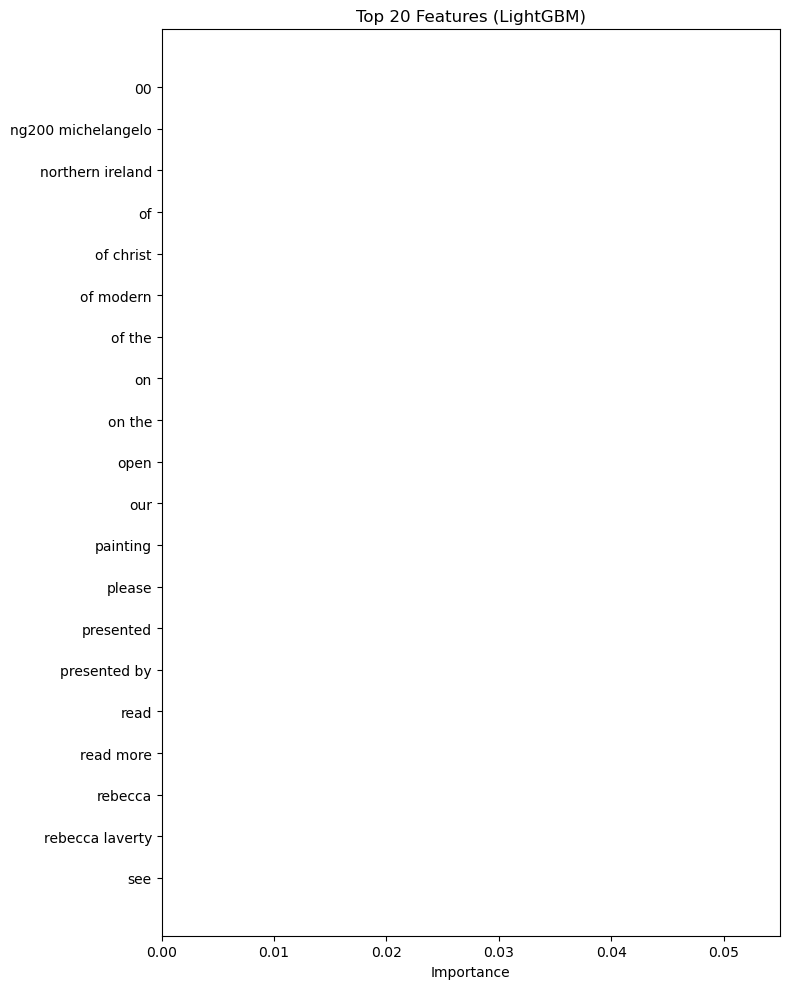

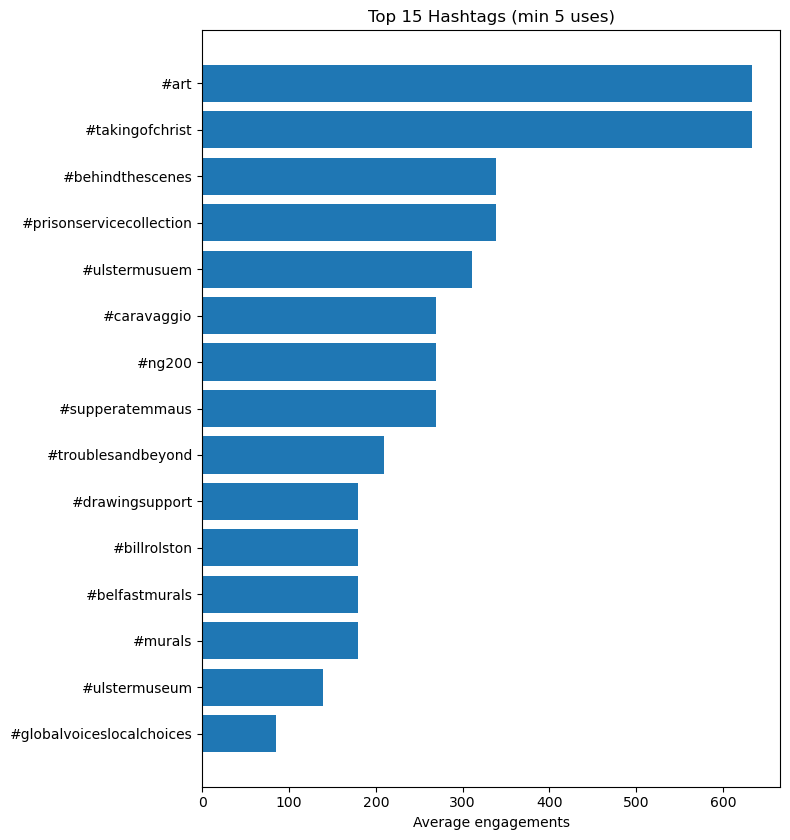

No day_stats available to plot.


In [16]:
# =============================
# 17) Visualizations 
# =============================
import os, re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

PLOT_DIR = "/Users/faitusjelinejoseph/Documents/Project/Social/plots"
os.makedirs(PLOT_DIR, exist_ok=True)

# Recompute y_true/y_pred on test for safety (uses best_pipe, X_test, y_test)
y_pred_log = best_pipe.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test.to_numpy())

# ---- 17.1 Predicted vs. Actual ----
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.6)
mx = max(float(np.max(y_true)), float(np.max(y_pred))) if len(y_true) else 1.0
plt.plot([0, mx], [0, mx], linestyle='--')
plt.xlabel("Actual engagements")
plt.ylabel("Predicted engagements")
plt.title("Predicted vs. Actual (test set)")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "predicted_vs_actual.png"), dpi=150)
plt.show()

# ---- 17.2 Residuals vs. Prediction ----
residuals = y_true - y_pred
plt.figure(figsize=(7, 5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted engagements")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predicted")
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "residuals_vs_predicted.png"), dpi=150)
plt.show()

# ---- 17.3 Top feature importances (robust to gain/permutation/old 'importance') ----
top_n = 20

# pick the most informative DF available
if 'importances_sorted' in globals():
    _imp = importances_sorted.copy()
elif 'importances' in globals():
    _imp = importances.copy()
else:
    _imp = pd.DataFrame(columns=['feature', 'importance'])

if 'perm' in _imp.columns:
    importance_df = _imp[['feature', 'perm']].rename(columns={'perm': 'importance'})
    xlabel = "Importance (permutation)"
elif 'gain' in _imp.columns:
    importance_df = _imp[['feature', 'gain']].rename(columns={'gain': 'importance'})
    xlabel = "Importance (gain)"
elif 'importance' in _imp.columns:
    importance_df = _imp[['feature', 'importance']]
    xlabel = "Importance"
else:
    importance_df = pd.DataFrame({'feature': [], 'importance': []})
    xlabel = "Importance"

top_imp = importance_df.head(top_n).iloc[::-1]  # reverse for horizontal barh
plt.figure(figsize=(8, 0.45 * max(1, len(top_imp)) + 1))
plt.barh(top_imp["feature"], top_imp["importance"])
plt.xlabel(xlabel)
plt.title(f"Top {len(top_imp)} Features (LightGBM)")
plt.xlim(left=0)
plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "feature_importance_top.png"), dpi=150)
plt.show()

# ---- 17.4 Best hashtags by average engagement ----
if 'tag_stats' in globals() and isinstance(tag_stats, pd.DataFrame) and not tag_stats.empty:
    top_tags_n = 15
    ts = tag_stats.head(top_tags_n).iloc[::-1]  # highest at top
    plt.figure(figsize=(8, 0.5 * min(top_tags_n, len(ts)) + 1))
    plt.barh(ts["hashtags"], ts["avg_engagement"])
    plt.xlabel("Average engagements")
    plt.title(f"Top {min(top_tags_n, len(ts))} Hashtags (min 5 uses)")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "top_hashtags.png"), dpi=150)
    plt.show()
else:
    print("No hashtag stats available to plot (tag_stats empty).")

# ---- 17.5 Best posting day per museum (historical averages) ----
if 'day_stats' in globals() and isinstance(day_stats, pd.DataFrame) and not day_stats.empty:
    museums = day_stats["museum_name"].dropna().unique().tolist()
    for m in museums:
        sub = day_stats[day_stats["museum_name"] == m].copy()
        if sub.empty:
            continue
        plt.figure(figsize=(8, 4))
        plt.bar(sub["day_of_week"].astype(str), sub["avg_engagement"])
        plt.ylabel("Avg engagements")
        plt.xlabel("Day of week")
        plt.title(f"Best Posting Day — {m}\n(Avg engagements, n={int(sub['posts'].sum())} posts)")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        fname = f"best_day_{re.sub(r'[^A-Za-z0-9]+','_', m)}.png"
        plt.savefig(os.path.join(PLOT_DIR, fname), dpi=150)
        plt.show()
else:
    print("No day_stats available to plot.")

# ---- 17.6 What-if: predicted engagement by day-of-week ----
def plot_predicted_by_day(museum_name=None, platform=None, caption="", month=None):
    """
    Month is integer 1-12. If None, uses the most frequent month in your data.
    """
    # sensible defaults
    if museum_name is None:
        museum_name = df["museum_name"].dropna().mode().iloc[0]
    if platform is None:
        platform = df["platform"].dropna().mode().iloc[0]
    if month is None:
        month = int(pd.Series(df["month"]).dropna().mode().iloc[0])

    days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    preds = []
    for dname in days:
        # craft a date in the requested month that falls on weekday dname
        base = pd.Timestamp(year=2024, month=int(month), day=1)
        target_idx = days.index(dname)  # 0=Mon..6=Sun
        delta = (target_idx - base.dayofweek) % 7
        date_d = base + pd.Timedelta(days=delta)

        p = predict_engagement(
            caption=caption,
            museum_name=museum_name,
            platform=platform,
            post_date=str(date_d.date())
        )
        preds.append(p)

    plt.figure(figsize=(8, 4))
    plt.bar(days, preds)
    plt.ylabel("Predicted engagements")
    plt.xlabel("Day of week")
    plt.title(f"What-if: Predicted Engagement by Day\n{museum_name} • {platform} • month={month}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "whatif_by_day.png"), dpi=150)
    plt.show()

# ---- 17.7 What-if: predicted engagement vs hashtag count ----
def plot_predicted_vs_hashtags(museum_name=None, platform=None, day_name="Wednesday", month=None, base_caption="Great exhibits today"):
    if museum_name is None:
        museum_name = df["museum_name"].dropna().mode().iloc[0]
    if platform is None:
        platform = df["platform"].dropna().mode().iloc[0]
    if month is None:
        month = int(pd.Series(df["month"]).dropna().mode().iloc[0])

    # craft a date for the chosen weekday
    days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    base = pd.Timestamp(year=2024, month=int(month), day=1)
    target_wd = days.index(day_name)
    delta = (target_wd - base.dayofweek) % 7
    post_date = str((base + pd.Timedelta(days=delta)).date())

    counts = list(range(0, 16))  # 0..15 hashtags
    preds = []
    for k in counts:
        tags = " ".join([f"#tag{i}" for i in range(1, k+1)])
        cap = (base_caption + " " + tags).strip()
        preds.append(predict_engagement(cap, museum_name, platform, post_date))

    plt.figure(figsize=(8, 4))
    plt.plot(counts, preds, marker='o')
    plt.xlabel("Hashtag count")
    plt.ylabel("Predicted engagements")
    plt.title(f"What-if: Predicted Engagement vs Hashtags\n{museum_name} • {platform} • {day_name} • month={month}")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "whatif_vs_hashtags.png"), dpi=150)
    plt.show()



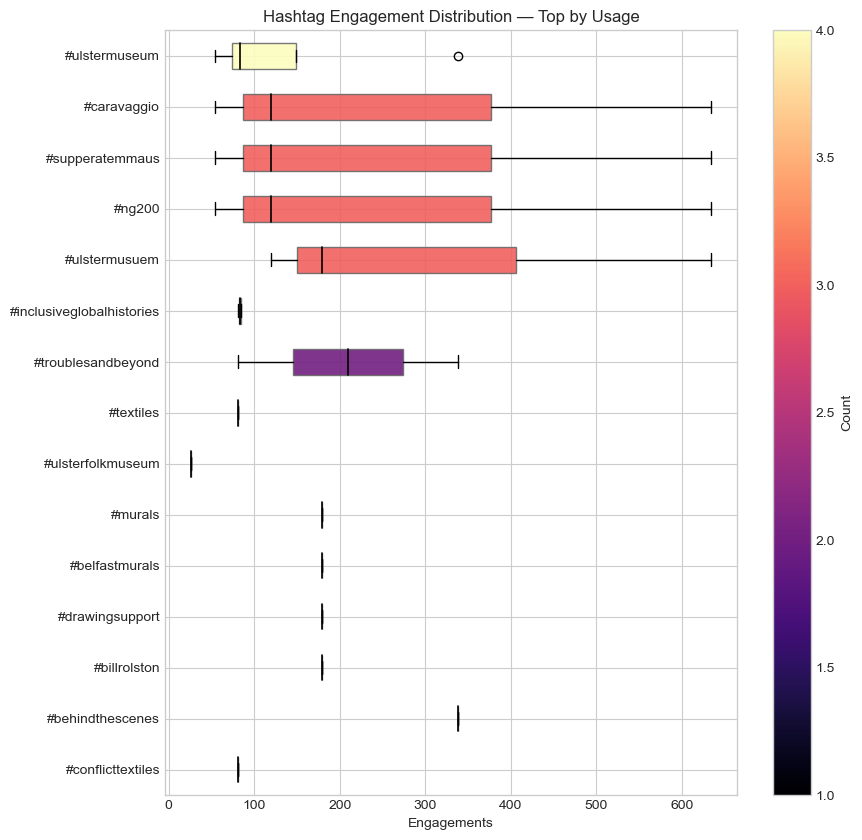

No data for: Hashtag Engagement Distribution — Top by Avg Engagement (≥5 uses)


In [24]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd

# (Optional) define if not already present
# import re
# def extract_hashtags(text):
#     if not isinstance(text, str): return []
#     return [h.lower() for h in re.findall(r'#\w+', text)]

tmp = df[['caption','engagements']].copy()
tmp['caption'] = tmp['caption'].fillna('')
tmp['engagements'] = pd.to_numeric(tmp['engagements'], errors='coerce')
tmp['hashtags'] = tmp['caption'].apply(extract_hashtags)
tmp = tmp.explode('hashtags').dropna(subset=['hashtags', 'engagements'])

# Top by usage
top_cnt = (tmp['hashtags'].value_counts()
           .head(15)
           .rename_axis('hashtags')
           .reset_index(name='count'))

# Top by avg engagement (require min uses to reduce noise)
top_avg = (tmp.groupby('hashtags')['engagements']
             .agg(count='size', avg_engagement='mean')
             .query('count >= 5')
             .sort_values(['avg_engagement','count'], ascending=[False, False])
             .head(15)
             .reset_index())

def _boxplot_by_hashtag(tmp_df, tags_df, metric_col, title, cmap_name="viridis"):
    """
    tmp_df: exploded post-level DF with columns ['hashtags','engagements']
    tags_df: DF with columns ['hashtags', metric_col] in desired order (desc)
    metric_col: column to use for coloring (e.g., 'count' or 'avg_engagement')
    """
    if tags_df.empty:
        print(f"No data for: {title}")
        return

    # Plot highest at top
    ordered_tags = tags_df['hashtags'].iloc[::-1].tolist()

    # Collect engagement arrays per tag
    data = [
        tmp_df.loc[tmp_df['hashtags'] == tag, 'engagements'].dropna().values
        for tag in ordered_tags
    ]

    # Build the boxplot
    plt.figure(figsize=(9, 0.5 * len(ordered_tags) + 1))
    bp = plt.boxplot(
        data,
        vert=False,
        patch_artist=True,          # allow facecolor
        labels=ordered_tags,
        showfliers=True,            # keep outliers visible
        medianprops=dict(color="black", linewidth=1.2),
        boxprops=dict(linewidth=1.0),
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0)
    )

    # Color boxes by the chosen metric
    vals = tags_df[metric_col].iloc[::-1].to_numpy()
    vmin = float(np.nanmin(vals))
    vmax = float(np.nanmax(vals)) if not np.isclose(np.nanmin(vals), np.nanmax(vals)) else vmin + 1.0
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)

    for patch, v in zip(bp['boxes'], vals):
        patch.set_facecolor(cmap(norm(v)))
        patch.set_alpha(0.9)
        patch.set_edgecolor("dimgray")

    # Colorbar legend
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label(metric_col.replace('_', ' ').title())

    plt.xlabel("Engagements")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# --- Box plot: Top hashtags by usage (colored by count) ---
_boxplot_by_hashtag(
    tmp_df=tmp,
    tags_df=top_cnt,                 # already top-15 by usage
    metric_col='count',
    title='Hashtag Engagement Distribution — Top by Usage',
    cmap_name='magma'
)

# --- Box plot: Top hashtags by avg engagement (≥5 uses; colored by avg_engagement) ---
_boxplot_by_hashtag(
    tmp_df=tmp,
    tags_df=top_avg[['hashtags','avg_engagement']],
    metric_col='avg_engagement',
    title='Hashtag Engagement Distribution — Top by Avg Engagement (≥5 uses)',
    cmap_name='cividis'
)
